# Assignment 6: scikit-learn
- **you will learn:** How to build end-to-end preprocessing pipelines, combine them with different regression models, and evaluate their performance
- **task:**  See section 6.6 below
- **deadline:** 15.12.2025
- [scikit-learn webpage](https://scikit-learn.org/)
- 📝 **Reminder:** Sync your GitHub repository with the main course repository, update your project in PyCharm, and after completing the assignment, commit and push your changes back to GitHub.
---

In [43]:
import numpy as np
import pandas as pd
import sklearn as sk
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Scikit learn version:", sk.__version__)

NumPy version: 2.3.3
Pandas version: 2.3.3
Scikit learn version: 1.7.2


## **6.1 Introduction to scikit-learn**

In this session, we will learn how to use **scikit-learn** not only as a library of machine learning models,
but mainly as a **framework** for:

- data preparation and preprocessing,
- building end-to-end pipelines,
- reproducible and correct model evaluation.

We intentionally avoid complex models.
Our goal is to understand the **scikit-learn workflow**, not to achieve state-of-the-art performance.

###  *What is scikit-learn?*

Scikit-learn is built on the concept of **estimators** — objects that follow a simple and unified API:

- `fit(X, y)` — learn from the data
- `predict(X)` — make predictions
- `transform(X)` — transform the data (for preprocessing)

Everything in scikit-learn that learns from data is an **estimator**.

Before diving deeper, here is the simplest possible sklearn model:

```python
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
```

### *Estimators vs Transformers*

- **Estimator**: any object that implements `fit()`.
  It can **learn from data**.
  Examples: LinearRegression, RandomForestRegressor, StandardScaler.

- **Transformer**: a special type of estimator that also implements `transform()`.
  It can **modify data** (e.g., scale, encode, impute).
  Examples: StandardScaler, OneHotEncoder, SimpleImputer.

- **Model vs Transformer**:
  - Model: usually `fit` + `predict`
  - Transformer: usually `fit` + `transform` (or `fit_transform`)
  - Pipelines can combine both into a single workflow.

> In short: *Every transformer is an estimator, but not every estimator is a transformer.*

### *The typical scikit-learn workflow*

1. Load the dataset
2. Inspect the structure of the data
3. Split the dataset into train/test
4. Create preprocessing steps
5. Combine preprocessing + model into a **Pipeline**
6. Train (`fit`)
7. Validate on independent data

---

### *Dataset*

We use the built-in **California Housing** dataset.
The task is to predict the median house value in different regions of California.

In [44]:
from sklearn.datasets import fetch_california_housing

# Load dataset
X_old, y = fetch_california_housing(return_X_y=True, as_frame=True)
X = X_old.copy()

# Create one categorical feature based on HouseAge
X['HouseAge_cat'] = pd.cut(
    X['HouseAge'],
    bins=[0, 20, 50, np.inf],
    labels=['new', 'medium', 'old']
)

# Basic checks
print("X shape:", X.shape)
print("y size:", y.size)
print("Column types:\n", X.dtypes)

print("Head:")
display(X.head())

print("Description:")
display(X.describe())


X shape: (20640, 9)
y size: 20640
Column types:
 MedInc           float64
HouseAge         float64
AveRooms         float64
AveBedrms        float64
Population       float64
AveOccup         float64
Latitude         float64
Longitude        float64
HouseAge_cat    category
dtype: object
Head:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HouseAge_cat
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,medium
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,medium
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,old
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,old
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,old


Description:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


## 6.2 **Train-test split**

In machine learning, we usually split our dataset into:

- **Training set** – used to fit the model
- **Test set** – used to evaluate the model on unseen data

This is important to check if our model **generalizes** to new data.
Without a test set, we might think our model is perfect, but it could just be **overfitting** to the training data.



We will use `sklearn.model_selection.train_test_split` for this.


In [45]:
from sklearn.model_selection import train_test_split
# Simple 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% of data for testing
    random_state=42,      # reproducibility
    shuffle=True          # shuffle data before splitting
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (16512, 9)
Test set shape: (4128, 9)


### Key Points

- Always split the data **before any preprocessing or model fitting**.
- `test_size=0.2` is common, but can be adjusted depending on dataset size.
- `random_state` ensures reproducibility: every time you use the same seed, the **random shuffling** happens the same way.
- `shuffle=True` (default) ensures training and test sets are representative.
  Use `shuffle=False` for time-dependent data.
- Check that the target distribution in train and test sets is roughly similar:

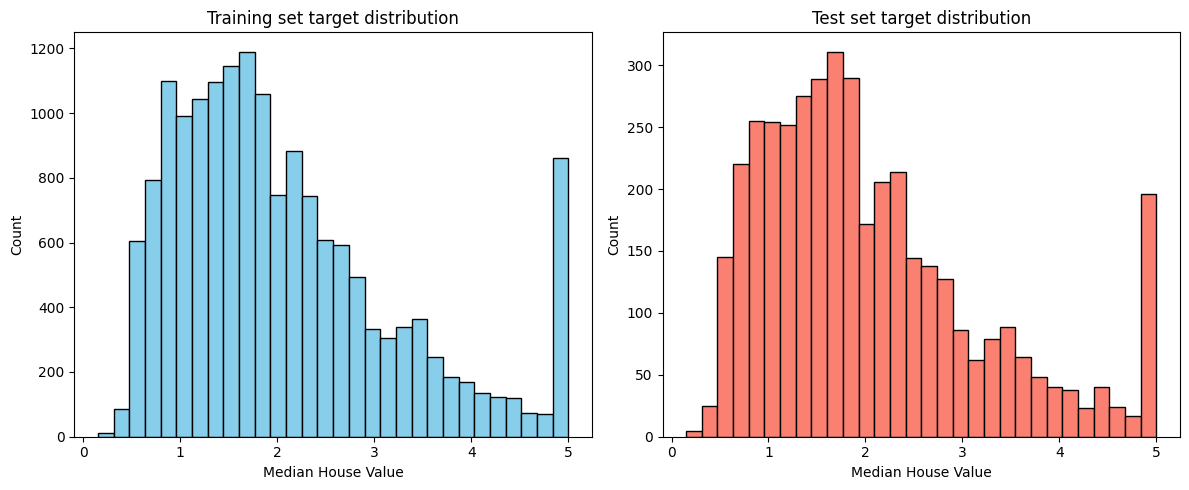

In [46]:
import matplotlib.pyplot as plt

# Histogram of target for training and test set
plt.figure(figsize=(12,5))

# Training set
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, color='skyblue', edgecolor='black')
plt.title("Training set target distribution")
plt.xlabel("Median House Value")
plt.ylabel("Count")

# Test set
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=30, color='salmon', edgecolor='black')
plt.title("Test set target distribution")
plt.xlabel("Median House Value")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## **6.3 Preprocessing**

Before feeding data into a model, we often need to **preprocess** it.
Typical preprocessing steps:

- Scale numerical features
- Encode categorical features  

In [47]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

### What is a Transformer?

A **transformer** is an object that:

- Implements `fit()` – learns from the data
- Implements `transform()` – modifies data (e.g., scaling, encoding)
- Often provides `fit_transform()` as a shortcut

Examples:

- `StandardScaler` – scales numerical features
- `OneHotEncoder` – converts categorical variables into numeric format


### OneHotEncoder example

We take a small categorical column and see how OneHotEncoder works:


In [48]:
# Example categorical column
df = pd.DataFrame({"Color": ["red", "green", "blue", "green"]})

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded = encoder.fit_transform(df)

print("Original column:\n", df)
print("Feature names:", encoder.get_feature_names_out())
print("Encoded array:\n", encoded)

Original column:
    Color
0    red
1  green
2   blue
3  green
Feature names: ['Color_blue' 'Color_green' 'Color_red']
Encoded array:
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


### Combining transformers with ColumnTransformer

Suppose we have numerical and categorical columns:

- **Numerical**: continuous numbers
- **Categorical**: discrete categories

We can apply different transformers to different columns using `ColumnTransformer`, which allows you to **combine multiple transformers in one object**, which can then be directly used in a pipeline with a model.:

In [49]:
# Select features
numeric_features = ["MedInc", "Population"]
categorical_features = ["HouseAge_cat"]

# Define transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

# Combine transformers in a ColumnTransformer
# ---------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"  # other columns will be dropped
)

# Fit and transform training data ONLY
X_train_processed = preprocessor.fit_transform(X_train)
print("Processed training feature matrix shape:", X_train_processed.shape)
print("Processed training feature matrix:\n", X_train_processed[:5]) # show first 5 rows


# Compute and print mean of numeric features in training data
train_numeric_means = np.mean(X_train_processed[:, :len(numeric_features)], axis=0)
print("Mean of numeric features in training data (should be ~0):")
for name, mean_val in zip(numeric_features, train_numeric_means):
    print(f"{name}: {mean_val:.4f}")

Processed training feature matrix shape: (16512, 4)
Processed training feature matrix:
 [[-0.326196    0.76827628  0.          0.        ]
 [-0.03584338 -0.09890135  0.          0.        ]
 [ 0.14470145 -0.44981806  1.          0.        ]
 [-1.01786438 -0.00743434  0.          0.        ]
 [-0.17148831 -0.48587717  0.          0.        ]]
Mean of numeric features in training data (should be ~0):
MedInc: -0.0000
Population: 0.0000


In [50]:
# Transform test data using the preprocessor fitted on training data
X_test_processed = preprocessor.transform(X_test)
print("Processed test feature matrix shape:", X_test_processed.shape)
print("Test data transformed using the same parameters as training data:")
print(X_test_processed[:5])  # show first 5 rows


# Compute and print mean of numeric features in test data
test_numeric_means = np.mean(X_test_processed[:, :len(numeric_features)], axis=0)
print("Mean of numeric features in test data (may NOT be 0):")
for name, mean_val in zip(numeric_features, test_numeric_means):
    print(f"{name}: {mean_val:.4f}")


Processed test feature matrix shape: (4128, 4)
Test data transformed using the same parameters as training data:
[[-1.15508475 -0.03030109  0.          0.        ]
 [-0.70865905  0.12185077  0.          0.        ]
 [-0.21040155 -0.10241931  0.          1.        ]
 [ 0.97511311  0.24497944  1.          0.        ]
 [-0.08179356 -0.31965346  0.          0.        ]]
Mean of numeric features in test data (may NOT be 0):
MedInc: -0.0265
Population: -0.0043


### Other Common Transformers in scikit-learn

Scikit-learn provides many transformers to preprocess or modify data. Some common ones:

  - `MinMaxScaler()` → scales features to a fixed range [0,1]
  - `RobustScaler()` → scales features using median and IQR (robust to outliers)
  - `OrdinalEncoder()` → converts categories to integer labels
  - `PolynomialFeatures(degree=2)` → generates polynomial and interaction features
  - `SimpleImputer(strategy="mean")` → fills missing values with mean
  - `SimpleImputer(strategy="most_frequent")` → fills missing with mode


## **6.4 Pipeline: Combining Preprocessing with a Model**

In scikit-learn, the recommended workflow is to combine all preprocessing steps
(imputation, scaling, encoding, etc.) with the machine learning model itself
into a single unified `Pipeline`.

### Why use a pipeline?

- The model receives **clean, consistently preprocessed data** every time.
- Preprocessing is automatically applied during:
  - fitting on the training set,
  - evaluation on the test/validation set,
  - later inference on new unseen data.
- The workflow becomes **clean, modular, reproducible, and maintainable**.

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Attach the model to the preprocessing pipeline
model = Pipeline(steps=[
    ("preprocessing", preprocessor),  # previously defined ColumnTransformer
    ("regressor", LinearRegression())  # any scikit-learn estimator
])

- The first element in each step of the pipeline is a **name** (string) used for reference.
- The second element is a **transformer or estimator** object.
- The last step must be an **estimator** (e.g., `LinearRegression`, `RandomForestRegressor`, etc.).
- All intermediate steps must implement `fit` and `transform`. The final step must implement `fit` and `predict`.
- Using a `Pipeline` ensures that the **entire workflow** (preprocessing + model) is evaluated consistently.
  - Example: during cross-validation, preprocessing is applied only on training folds.
- Prevents **data leakage** by ensuring that preprocessing statistics (e.g., mean/std) are learned **only from training data**.
- Makes the workflow **modular, reproducible, and maintainable**.

## **6.5 Fitting and Evaluating on the Test Set**

- Now that we have a complete `Pipeline` (preprocessing + model), we can **fit it** on the training data:
  - All preprocessing steps are applied automatically.
  - The model is trained on the transformed features.
- This ensures that the **entire workflow** is applied consistently and prevents data leakage.


In [52]:
model.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [53]:
# The last step in the pipeline is the regressor
regressor = model.named_steps["regressor"]

# Coefficients of the linear regression model
coefficients = regressor.coef_
intercept = regressor.intercept_

print("Intercept:", intercept)
print("Coefficients:", coefficients)

# Optionally, match coefficients to feature names
# For numeric features + one-hot encoded categorical features, we need names
# Get numeric feature names
numeric_features = ["MedInc", "Population"]
# Get categorical feature names after one-hot encoding
cat_feature_names = model.named_steps["preprocessing"].named_transformers_["cat"].get_feature_names_out(["HouseAge_cat"])

# Combine all feature names
feature_names = numeric_features + list(cat_feature_names)

# Print coefficients with feature names
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.4f}")

Intercept: 2.1277019114540505
Coefficients: [ 0.81173272  0.01572627 -0.31271952  0.62279539]
MedInc: 0.8117
Population: 0.0157
HouseAge_cat_new: -0.3127
HouseAge_cat_old: 0.6228



Once we have trained our full pipeline (preprocessing + model), the last step is
to evaluate how well it performs on data that the model has **never seen** — the
test set.


### Why evaluate on a separate test set?

- To simulate real-world performance on new unseen data.
- To detect overfitting (model performs much better on training data than on test data).
- To estimate the generalization ability of our pipeline.

### Common regression metrics

- **R² score**: measures proportion of variance explained by the model.
  - R² = 1 → perfect predictions
  - R² = 0 → model is no better than predicting the mean
- **Mean Absolute Error (MAE)**: average absolute difference between predictions and true values.
- **Root Mean Squared Error (RMSE)**: square root of MSE; penalizes larger errors more and is in the same units as the target.

In [54]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Predict on the test data
y_pred = model.predict(X_test)

# Compute evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display results
print(f"Test R² score:       {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"RMSE:                {rmse:.4f}")

Test R² score:       0.4953
Mean Absolute Error: 0.6053
RMSE:                0.8132


## 6.6  **Homework: Custom Preprocessing + Model Comparison**

Your goal is to design a custom preprocessing pipeline for the California Housing dataset and compare the performance of three different regression models.
Because several transformations must be applied to the **same columns in sequence**, you must use **Pipeline** objects inside a **ColumnTransformer**.


### 1. Dataset (same as before)
Use the California Housing dataset. Split the data into `train` and `test`.

### 2. Preprocessing Requirements

#### A. Numerical features using **StandardScaler → PolynomialFeatures**
Apply these two transformations **in this exact order** to the features:

- `MedInc`
- `Population`

Steps:
1. First apply `StandardScaler()`
2. Then apply `PolynomialFeatures(degree=2, include_bias=False)`

#### B. Numerical features using **MinMaxScaler → PolynomialFeatures**
Apply these two transformations **in this exact order** to the features:

- `Latitude`
- `Longitude`

Steps:
1. First apply `MinMaxScaler(feature_range=(0, 1))`
2. Then apply `PolynomialFeatures(degree=2, include_bias=False)`

#### C. Categorical features using OneHotEncoder (same as before)
Apply:

- `OneHotEncoder(handle_unknown="ignore")`

to the feature:

- `HouseAge_cat`

### 3. How to chain multiple transformations
Because you need two transformations applied sequentially to the same variables, you must wrap them inside `Pipeline([...])`.

Example structure (you must implement both variants):

```
Pipeline([
    ("scaler", Transformer_1),
    ("poly", Transformer_2)
])
```

Then include these pipelines inside a `ColumnTransformer`.

## 4. Combine everything
Use a `ColumnTransformer` with three parts:

1. StandardScaler → PolynomialFeatures for (`MedInc`, `Population`)
2. MinMaxScaler → PolynomialFeatures for (`Latitude`, `Longitude`)
3. OneHotEncoder for (`HouseAge_cat`)

## 5. Models to train
Train the following three models on the **same preprocessing pipeline**:

1. `LinearRegression`
2. `Ridge` (with default parameters)
3. `DecisionTreeRegressor` (with default parameters)

For each model, create a full pipeline:

```
Pipeline([
    ("preprocess", preprocessor),
    ("regressor", ...)
])
```
Fit all three models on the training set.


## 6. Evaluation
For each model, compute the **RMSE on the test set**:

```
RMSE = sqrt(mean_squared_error(y_test, y_pred))
```

Print the test RMSE for all three models and compare their performance.

In [55]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

In [56]:
print("1.")
from sklearn.datasets import fetch_california_housing

# Load dataset
X_old, y = fetch_california_housing(return_X_y=True, as_frame=True)
X = X_old.copy()

# Create one categorical feature based on HouseAge
X['HouseAge_cat'] = pd.cut(
    X['HouseAge'],
    bins=[0, 20, 50, np.inf],
    labels=['new', 'medium', 'old']
)

from sklearn.model_selection import train_test_split
# Simple 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% of data for testing
    random_state=42,      # reproducibility
    shuffle=True          # shuffle data before splitting
)


1.


In [57]:
print("2.A+3.")
# Select features
numeric_features = ["MedInc", "Population"]

# Define transformers
numeric_transformer = StandardScaler()
polynomial_transformer = PolynomialFeatures(degree=2, include_bias=False)

#Create a pipeline
num_poly_pipeline = Pipeline(steps=[("num", numeric_transformer),
        ("poly", polynomial_transformer)])


2.A+3.


In [58]:
print("2.B+3.")
#Select features
numeric_features1 = ["Latitude","Longitude"]
# Define transformer
minmax_transformer= MinMaxScaler(feature_range=(0, 1))
#Create a pipeline
minmax_poly_pipeline = Pipeline(steps=[("minmax", minmax_transformer),("poly",polynomial_transformer)])


2.B+3.


In [59]:
print("2.C+3.")
# Select features
categorical_features = ["HouseAge_cat"]

# Define transformer
categorical_transformer = OneHotEncoder(handle_unknown="ignore")


2.C+3.


In [60]:
print("4.")
# Combine transformers in a ColumnTransformer
# ---------------------------
preprocessorALL = ColumnTransformer(
    transformers=[
        ("num_poly", num_poly_pipeline, numeric_features),
        ("minmax_poly", minmax_poly_pipeline, numeric_features1),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

4.


In [61]:
print("5.1")
# Attach the models to the preprocessing pipeline
pipeline_lr = Pipeline([
    ("preprocess", preprocessorALL),
    ("regressor", LinearRegression())
])

pipeline_lr.fit(X_train, y_train)

5.1


,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_poly', ...), ('minmax_poly', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [62]:
print("5.2")
pipeline_ridge = Pipeline([
    ("preprocess", preprocessorALL),
    ("regressor", Ridge())
])

pipeline_ridge.fit(X_train, y_train)

5.2


,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_poly', ...), ('minmax_poly', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [63]:
print("5.3")
pipeline_tree = Pipeline([
    ("preprocess", preprocessorALL),
    ("regressor", DecisionTreeRegressor())
])

pipeline_tree.fit(X_train, y_train)


5.3


,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_poly', ...), ('minmax_poly', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [64]:
print("6.")
y_pred_lr=pipeline_lr.predict(X_test) #Predict on the test data
rmse_lr=np.sqrt(mean_squared_error(y_test, y_pred_lr)) #computes RMSE

y_pred_ridge=pipeline_ridge.predict(X_test)
rmse_ridge=np.sqrt(mean_squared_error(y_test, y_pred_ridge))

y_pred_tree=pipeline_tree.predict(X_test)
rmse_tree=np.sqrt(mean_squared_error(y_test, y_pred_tree))

print(f"Linear Regression RMSE: {rmse_lr:.4f}",f"Ridge RMSE: {rmse_ridge:.4f}",f"Tree RMSE: {rmse_tree:.4f}")

6.
Linear Regression RMSE: 0.7177 Ridge RMSE: 0.7306 Tree RMSE: 0.6472


In [65]:
print("The Decision Tree model has the lowest RMSE, while Linear Regression and Ridge have similar RMSEs.")

The Decision Tree model has the lowest RMSE, while Linear Regression and Ridge have similar RMSEs.
